In [1]:
import jax.numpy as np
import numpy as onp
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)

# data (as pandas dataframes)
X_df = breast_cancer_wisconsin_original.data.features
y_df = breast_cancer_wisconsin_original.data.targets

# metadata
print(breast_cancer_wisconsin_original.metadata)

# variable information
print(breast_cancer_wisconsin_original.variables)

# Remove rows with missing values
nan_indexes = X_df[X_df.isna().any(axis=1)].index
X_df = X_df.drop(nan_indexes)
y_df = y_df.drop(nan_indexes)


# Convert DataFrames to numpy arrays
X = np.asarray(X_df.to_numpy(), dtype=float)
y = np.asarray(y_df.to_numpy() / 2 - 1.0)

{'uci_id': 15, 'name': 'Breast Cancer Wisconsin (Original)', 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original', 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv', 'abstract': 'Original Wisconsin Breast Cancer Database', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 699, 'num_features': 9, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['Class'], 'index_col': ['Sample_code_number'], 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1990, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5HP4Z', 'creators': ['WIlliam Wolberg'], 'intro_paper': None, 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, having been removed fro

I0000 00:00:1700431729.786341       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
X.shape, y.shape

((683, 9), (683, 1))

In [3]:
from jax import jit, grad, lax


@jit
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@jit
def log_pred(beta: np.ndarray, X: np.ndarray) -> np.ndarray:
    print(X)
    print(beta)
    print(beta.shape, X.shape)
    return sigmoid(np.dot(X, beta))


@jit
def log_loss(
    inputs: np.ndarray, targets: np.ndarray, weights: np.ndarray, lmbda: float = 0
) -> float:
    pred = log_pred(weights, inputs)
    label_probs = pred * targets + (1 - pred) * (1 - targets)
    return (
        -np.sum(np.log(label_probs + 1e-7))
        + lmbda * np.dot(weights.T, weights).squeeze()
    )

In [4]:
from Gradients import Gradients
from Schedules import Constant, Adagrad

grads = Gradients(
    X.shape[0], X, y, log_loss, polynomial=False, scheduler=Adagrad(0.001), lmbda=1
)

In [5]:
onp.random.seed(2023)
# beta = onp.random.randn(X.shape[1], 1)
beta = np.zeros((X.shape[1], 1))

beta_fix = grads.StochasticGradientDescent(beta, 50, 50)

Traced<ShapedArray(float32[50,9])>with<DynamicJaxprTrace(level=5/0)>
Traced<ShapedArray(float32[9,1])>with<DynamicJaxprTrace(level=5/0)>
(9, 1) (50, 9)
Traced<ShapedArray(float32[683,9])>with<DynamicJaxprTrace(level=2/0)>
Traced<ShapedArray(float32[9,1])>with<DynamicJaxprTrace(level=2/0)>
(9, 1) (683, 9)


In [6]:
np.sum((log_pred(beta_fix, X) > 0.5) == y) / y.size

Array(0.8579795, dtype=float32)

In [7]:
final_pred = log_pred(beta_fix, X) > 0.5

In [8]:
np.sum(np.abs(final_pred - y))

Array(97., dtype=float32)

In [9]:
np.dot(beta.T, beta).squeeze()

Array(0., dtype=float32)

In [10]:
from grad_analysis import GradAnalysis
from pathlib import Path

basePath = Path.cwd().parent.parent / "figures/logreg"
basePath.mkdir(parents=True, exist_ok=True)

GA = GradAnalysis(
    X,
    y,
    100,
    2023,
    log_loss,
    base_theta=beta,
    lmbda=0.001,
    figspath=basePath,
    polynomial=False,
)

In [11]:
GA.minibatch_analysis(8)

/Users/augustfemtehjell/opt/miniconda3/envs/fysstk/lib/python3.11/site-packages/jax/_src/numpy/reductions.py:230: UserWarning: Explicitly requested dtype <class 'numpy.int64'> requested in prod is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "prod", np.prod, lax.mul, 1, preproc=_cast_to_numeric,


Traced<ShapedArray(float32[100,9])>with<DynamicJaxprTrace(level=5/0)>
Traced<ShapedArray(float32[9,1])>with<DynamicJaxprTrace(level=5/0)>
(9, 1) (100, 9)
Traced<ShapedArray(float32[99,9])>with<DynamicJaxprTrace(level=5/0)>
Traced<ShapedArray(float32[9,1])>with<DynamicJaxprTrace(level=5/0)>
(9, 1) (99, 9)
Traced<ShapedArray(float32[98,9])>with<DynamicJaxprTrace(level=5/0)>
Traced<ShapedArray(float32[9,1])>with<DynamicJaxprTrace(level=5/0)>
(9, 1) (98, 9)
Traced<ShapedArray(float32[97,9])>with<DynamicJaxprTrace(level=5/0)>
Traced<ShapedArray(float32[9,1])>with<DynamicJaxprTrace(level=5/0)>
(9, 1) (97, 9)


TypeError: Cannot determine dtype of [174  94 333 681 621 561 171 376 503 134 484 256 337 672 276 111 479 634
   5   3 140 240 433 292 635  82 673 167 237 355 621 271 234 315 367 579
 593 645  31  56 649 680 389 489 379 548 502 453  73 522 485 124 443 392
  14 575 551 287 250 555 166 175 420 514 153 552 536  37 659 432 357  27
 675 428 582 300 513 494 432 492 547 192  44 244 341 109 474 668 613 650
   8 176 127 101 382 253 626]

In [12]:
GA.gd_main(8)

ValueError: Incompatible shapes for broadcasting: (100,) and requested shape (683,)

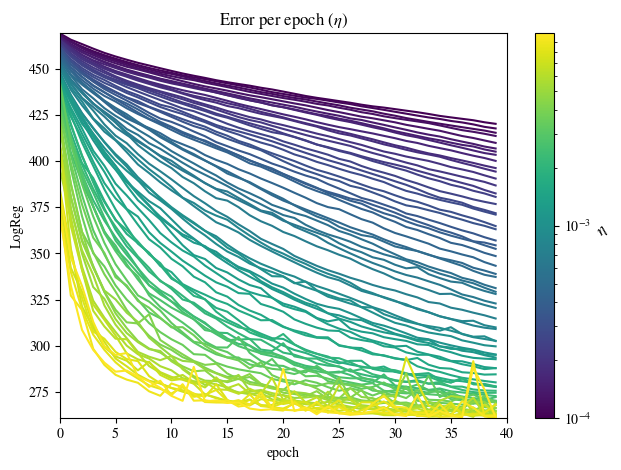

In [83]:
from utils import assign_row
from plotutils import PlotErrorPerVariable
from Schedules import Constant, Momentum, Adagrad, AdagradMomentum, Adam, RMS_prop

eta_num = 75
n_epochs = 40

eta_arr = np.logspace(-4, -2, eta_num)
BaseSchedules = [Constant, Momentum, Adagrad, AdagradMomentum, Adam, RMS_prop]
schedule_params = [(), (0.9,), (), (0.9,), (0.9, 0.999), (0.9)]
schedulers = [Adam(eta, 0.9, 0.999) for eta in eta_arr]
base_beta = np.zeros((X.shape[1], 1))

for BaseSchedule, params in zip(BaseSchedules, schedule_params):
    schedulers = [BaseSchedule(eta, *params) for eta in eta_arr]
    error_arr = np.zeros((eta_num, n_epochs))
    beta_arr = np.zeros((eta_num, X.shape[1]))

    for i, schedule in enumerate(schedulers):
        Gradient = Gradients(
            X.shape[0],
            X,
            y,
            log_loss,
            scheduler=schedule,
            lmbda=0.1,
            polynomial=False,
        )
        beta_arr = assign_row(
            beta_arr,
            i,
            Gradient.StochasticGradientDescent(base_beta, n_epochs, 50).ravel(),
        )
        error_arr = assign_row(
            error_arr,
            i,
            Gradient.errors,
        )
    PlotErrorPerVariable(
        error_arr,
        eta_arr,
        figsPath=basePath,
        error_label="LogReg",
        error_type="linear",
        colormap="viridis",
    )
for i, schedule in enumerate(schedulers):
    Gradient = Gradients(
        X.shape[0],
        X,
        y,
        log_loss,
        scheduler=schedule,
        lmbda=0.1,
        polynomial=False,
    )

    beta_arr = assign_row(
        beta_arr,
        i,
        Gradient.StochasticGradientDescent(base_beta, n_epochs, 50).ravel(),
    )

    error_arr = assign_row(error_arr, i, Gradient.errors)

In [84]:
error_arr.shape

(75, 40)

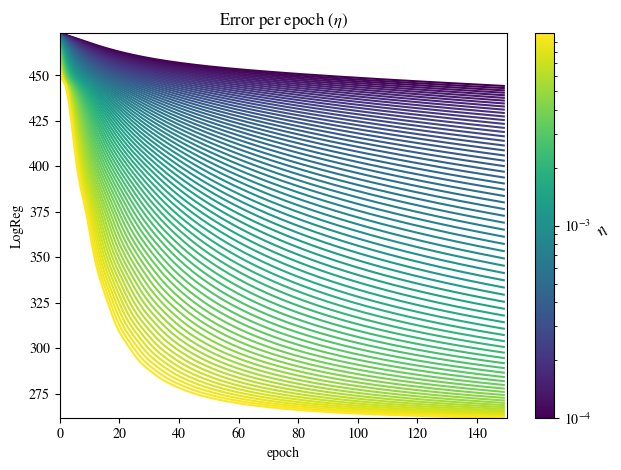

In [23]:
error_arr

Array([[ 461.8559 ,  454.47617,  449.48856, ...,  333.88922,  333.5535 ,
         333.2204 ],
       [ 460.5258 ,  452.8003 ,  447.7859 , ...,  327.73795,  327.41068,
         327.08606],
       [ 459.07605,  451.08002,  446.09283, ...,  321.76138,  321.4447 ,
         321.13083],
       ...,
       [7156.4365 , 7156.4365 , 7156.4365 , ..., 7156.4365 , 7156.4365 ,
        7156.4365 ],
       [7156.4365 , 7156.4365 , 7156.4365 , ..., 7156.4365 , 7156.4365 ,
        7156.4365 ],
       [7156.4365 , 7156.4365 , 7156.4365 , ..., 7156.4365 , 7156.4365 ,
        7156.4365 ]], dtype=float32)

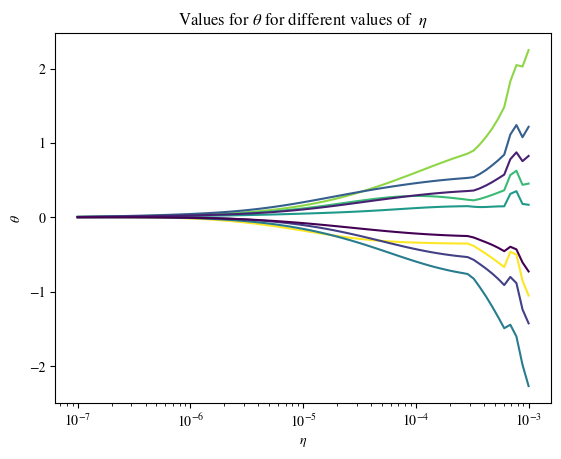

In [32]:
from plotutils import plotThetas

plotThetas(beta_arr, eta_arr, figsPath=basePath, colormap="viridis_r")